In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.8 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display
import kerastuner as kt
import random
import IPython

<ipython-input-2-fa8cf9b991d5>:24: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from kerastuner import HyperModel

In [ ]:
hp=kt.HyperModel

In [ ]:
from kerastuner.engine.hyperparameters import HyperParameters

# Define a float-valued hyperparameter
hp = HyperParameters()

In [ ]:
seed = 52
tf.random.set_seed(seed)
random.seed(seed)

(256, 256, 3)


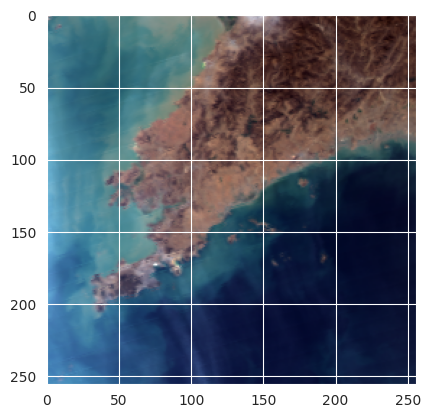

In [ ]:
#Checking for Image Loading
fpath=r'/content/drive/MyDrive/proj_dataset/data/Seaside/seaside_1.tif'
img=plt.imread(fpath)
print (img.shape)
imshow(img)

In [ ]:
#Data Indexing and Data Splitting
data_set_dir=r'/content/drive/MyDrive/proj_dataset/data/'
classlist=os.listdir(data_set_dir)
filepaths=[]
labels=[]
for classes in classlist:
    classpath=os.path.join(data_set_dir,classes)
    all_files_list=os.listdir(classpath)
    for file in all_files_list:
        eachpath=os.path.join(classpath,file)
        filepaths.append(eachpath)
        labels.append(classes)
File_series=pd.Series(filepaths, name='filepaths')
Label_series=pd.Series(labels, name='labels')
data_frame=pd.concat([File_series, Label_series], axis=1)
training_split= .9
v_split=.05
data_split=v_split/(1-training_split)
train_df, dummy_df = train_test_split(data_frame, train_size=training_split, shuffle=True, random_state=123)
valid_df, test_df = train_test_split(dummy_df, train_size=data_split, shuffle=True, random_state=123)
print('train_df length: ', len(train_df), '  test_df length: ',len(test_df), '  valid_df length: ', len(valid_df))
images_list=list(train_df['labels'].value_counts())
for i in images_list:
    print (i)

train_df length:  5602   test_df length:  312   valid_df length:  311
1049
923
911
911
906
902


In [ ]:
#Data Balancing
sample_list=[]
max_size= 902
min_size = 0
groups=train_df.groupby('labels')
for label in train_df['labels'].unique():
    group=groups.get_group(label)
    sample_count=len(group)
    if sample_count> max_size :
        samples=group.sample(max_size, replace=False, weights=None, random_state=123, axis=0).reset_index(drop=True)
        sample_list.append(samples)
    elif sample_count>= min_size:
        sample_list.append(group)
train_df=pd.concat(sample_list, axis=0).reset_index(drop=True)
print (len(train_df))
print (train_df['labels'].value_counts())

5412
Haze       902
Seaside    902
Cloud      902
Dust       902
Smoke      902
Land       902
Name: labels, dtype: int64


In [ ]:
#Parameter Initialization
height=150
width=150
channels=3
batch_size=3
img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

test batch size:  78   test steps:  4


In [ ]:
#Image Smoothening, Data Augumentation, Data Validation
def scalar(img):
    #img=img/127.5-1
    return img
trgen=ImageDataGenerator(preprocessing_function=scalar,
                        rotation_range=20,
                        horizontal_flip=True
                        )
tvgen=ImageDataGenerator(preprocessing_function=scalar)
train_gen=trgen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen=tvgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)
valid_gen=tvgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
classes=list(train_gen.class_indices.keys())
class_count=len(classes)
train_steps=np.ceil((len(train_gen.labels)/batch_size))

Found 5412 validated image filenames belonging to 6 classes.
Found 312 validated image filenames belonging to 6 classes.
Found 311 validated image filenames belonging to 6 classes.


In [ ]:
#Displaying the image
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())
    images,labels=next(gen)
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]/255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

In [ ]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m'
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True)
    return

## Building CNN Architecture

In [ ]:
def inner_block(  inputs, num_filters , hp ):
    layer = tf.keras.layers.BatchNormalization( epsilon=1.1e-5 )( inputs )
    layer = tf.keras.layers.Activation('relu')(layer)
    layer = tf.keras.layers.ZeroPadding2D((1, 1))(layer)
    layer = tf.keras.layers.Conv2D(num_filters, kernel_size=(3, 3), use_bias=False , kernel_initializer='he_normal' )(layer)
    drop_out_rate = hp.Float('dp_1', min_value=0.3, max_value=0.7, step=0.1)
    layer = tf.keras.layers.Dropout(drop_out_rate)(layer)
    return layer

In [ ]:
def combination_block( inputs, number_of_layers, num_filters, growth_rate , hp ):
    for i in range(number_of_layers):
        conv_outputs = inner_block(inputs, num_filters , hp )
        inputs = tf.keras.layers.Concatenate()([conv_outputs, inputs])
        num_filters += growth_rate
    return inputs, num_filters

In [ ]:
def transition_block(input_data, num_filters , compression_factor , hyper_parameter ):
    layer = tf.keras.layers.BatchNormalization( epsilon=1.1e-5 )(input_data)
    layer = tf.keras.layers.Activation('relu')(layer)
    num_maps = input_data.shape[1]
    layer = tf.keras.layers.Conv2D( np.floor( compression_factor * num_maps ).astype( np.int ) ,
                               kernel_size=(1, 1), use_bias=False, padding='same' ,
                               kernel_initializer='he_normal' ,
                               kernel_regularizer=tf.keras.regularizers.l2( 1e-4 ),
                               )(layer)
    hyper_parameter = hp.Float('dp_1', min_value=0.3, max_value=0.7, step=0.1)
    drop_out_rate = hp.Float('dp_1', min_value=0.3,max_value=0.7,step=0.1)
    drop_out_rate = tf.keras.layers.Dropout(drop_out_rate)(layer)
    layer = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(layer)
    return layer

## **Hyper-Parameter Tuning**

In [ ]:
def tune_model(hp):
    number_of_filters = 16
    input_size = (120,120,3)
    total_blocks = 4
    number_of_layers_for_each_block = 2
    growth_rate = 16
    compression_factor = 0.5
    input_data = tf.keras.layers.Input( shape=input_size )
    layer = tf.keras.layers.Conv2D( number_of_filters , kernel_size=(3,3) , use_bias=False, kernel_initializer='he_normal' , kernel_regularizer=tf.keras.regularizers.l2( 1e-4 ) )( input_data )
    for i in range( total_blocks ):
        layer, number_of_filters = combination_block( layer, number_of_layers_for_each_block , number_of_filters, growth_rate , hp )
        layer = transition_block(layer, number_of_filters , compression_factor , hp )
    layer = tf.keras.layers.GlobalAveragePooling2D()( layer )
    layer = tf.keras.layers.Dense(6)( layer )
    # output_layer = tf.keras.layers.Activation( 'softmaxlayer' )( layer )
    output_layer = tf.keras.activations.softmax( layer )
    model = tf.keras.models.Model( input_data , output_layer )
    model.compile( loss=tf.keras.losses.categorical_crossentropy ,optimizer=tf.keras.optimizers.Adam( lr=0.00075 ),metrics=[ 'acc' ])
    model.summary()
    return model

In [ ]:
def hyper_parameter_tuner():
    tuner = kt.Hyperband(hypermodel=tune_model,
                     objective='val_loss',
                     max_epochs=20,
                     factor=3,
                     hyperband_iterations=1,
                     seed=seed,
                     overwrite=True)

    early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

    tuner.search(train_gen, epochs=20,
              validation_data= valid_gen,
              verbose=1, callbacks=[early_stopping])


    return tuner

In [ ]:
tuner = hyper_parameter_tuner()

Trial 4 Complete [00h 02m 29s]
val_loss: 1.0628324747085571

Best val_loss So Far: 1.0387638807296753
Total elapsed time: 01h 15m 12s


In [ ]:
#tuner = hyper_parameter_tuner()
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
print(best_hps)
print(best_hps.get('dp_1'))

0.3


In [ ]:
#Training the Model
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_gen,epochs=20,
                    validation_data=valid_gen, verbose=2, batch_size=6)

<ipython-input-17-a3e7f68abd4b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  layer = tf.keras.layers.Conv2D( np.floor( compression_factor * num_maps ).astype( np.int ) ,


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 conv2d_13 (Conv2D)          (None, 118, 118, 16)         432       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_12 (Ba  (None, 118, 118, 16)         64        ['conv2d_13[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_12 (Activation)  (None, 118, 118, 16)         0         ['batch_normalization_12

### Model Evaluation

In [ ]:
def tr_plot(tr_data, start_epoch):
    training_accuracy=tr_data.history['acc']
    training_loss=tr_data.history['loss']
    validation_accuracy=tr_data.history['val_acc']
    validation_loss=tr_data.history['val_loss']
    Epoch_count=len(training_accuracy)+ start_epoch
    Number_of_epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Number_of_epochs.append(i+1)
    index_loss=np.argmin(validation_loss)
    val_lowest=validation_loss[index_loss]
    index_accuracy=np.argmax(validation_accuracy)
    acc_highest=validation_accuracy[index_accuracy]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_accuracy + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    fig.patch.set_facecolor('white')
    axes[0].plot(Number_of_epochs,training_loss, 'r', label='Training loss')
    axes[0].plot(Number_of_epochs,validation_loss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Number_of_epochs')
    axes[0].set_ylabel('Loss')
    axes[0].patch.set_facecolor('white')
    axes[0].grid(False)
    axes[0].legend()
    axes[1].plot (Number_of_epochs,training_accuracy,'r',label= 'Training Accuracy')
    axes[1].plot (Number_of_epochs,validation_accuracy,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_accuracy+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Number_of_epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].patch.set_facecolor('white')
    axes[1].grid(False)
    axes[1].legend()
    plt.tight_layout
    plt.show()

In [ ]:
def print_info( test_data, predictions, print_code, save_dir, subject ):
    dict_classes=test_data.class_indices
    labels= test_data.labels
    file_names= test_data.filenames
    list_error=[]
    true_values=[]
    predicted_classes=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in dict_classes.items():
        new_dict[value]=key
    classes=list(new_dict.values())
    num_errors=0
    for i, p in enumerate(predictions):
        predicted_index=np.argmax(p)
        accu_index=labels[i]
        if predicted_index != accu_index:
            list_error.append(file_names[i])
            true_values.append(new_dict[accu_index])
            predicted_classes.append(new_dict[predicted_index])
            prob_list.append(p[predicted_index])
            error_indices.append(accu_index)
            num_errors=num_errors + 1
        y_pred.append(predicted_index)
    if print_code !=0:
        if num_errors>0:
            if print_code>num_errors:
                r=num_errors
            else:
                r=print_code
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):
                split1=os.path.split(list_error[i])
                split2=os.path.split(split1[0])
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, predicted_classes[i],true_values[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if num_errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():
            count=error_indices.count(key)
            if count!=0:
                plot_bar.append(count)
                plot_class.append(value)
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        cm = confusion_matrix(y_true, y_pred )
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

In [ ]:
#Saving the Model
save_loc='./base_cnn_net.h5'
model.save(save_loc)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 161s 53s/step


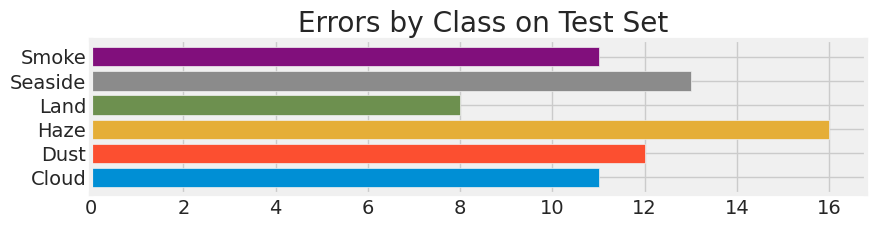

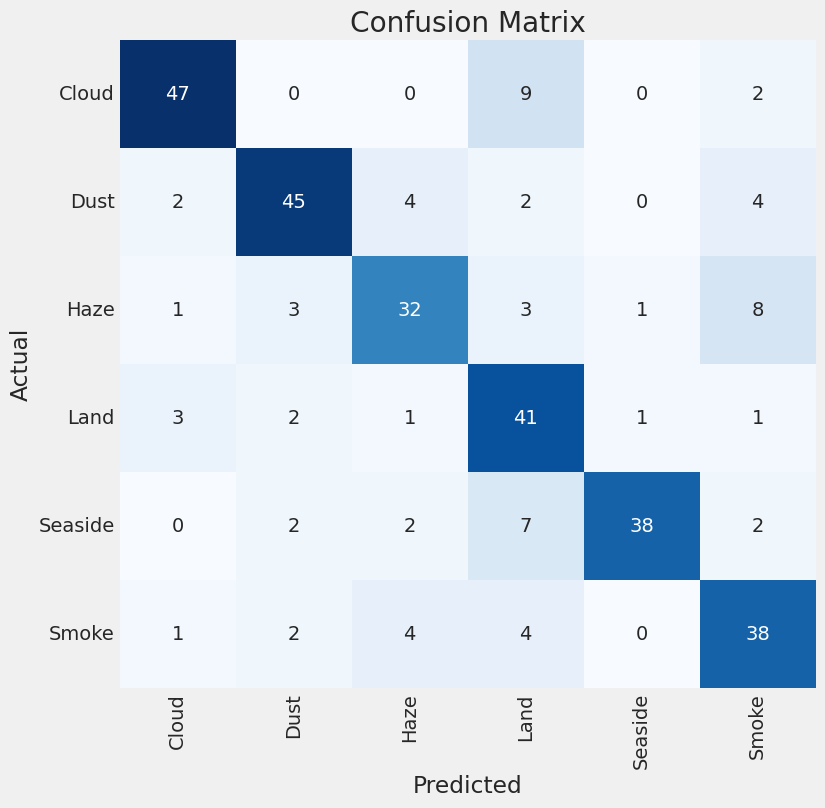

Classification Report:
----------------------
               precision    recall  f1-score   support

       Cloud       0.87      0.81      0.84        58
        Dust       0.83      0.79      0.81        57
        Haze       0.74      0.67      0.70        48
        Land       0.62      0.84      0.71        49
     Seaside       0.95      0.75      0.84        51
       Smoke       0.69      0.78      0.73        49

    accuracy                           0.77       312
   macro avg       0.79      0.77      0.77       312
weighted avg       0.79      0.77      0.78       312



In [ ]:
#Testing the Model
print_code=0
save_dir=r'./'
subject='scenes'
preds=model.predict(test_gen)
print_info( test_gen, preds, print_code, save_dir, subject )

### Model Performance

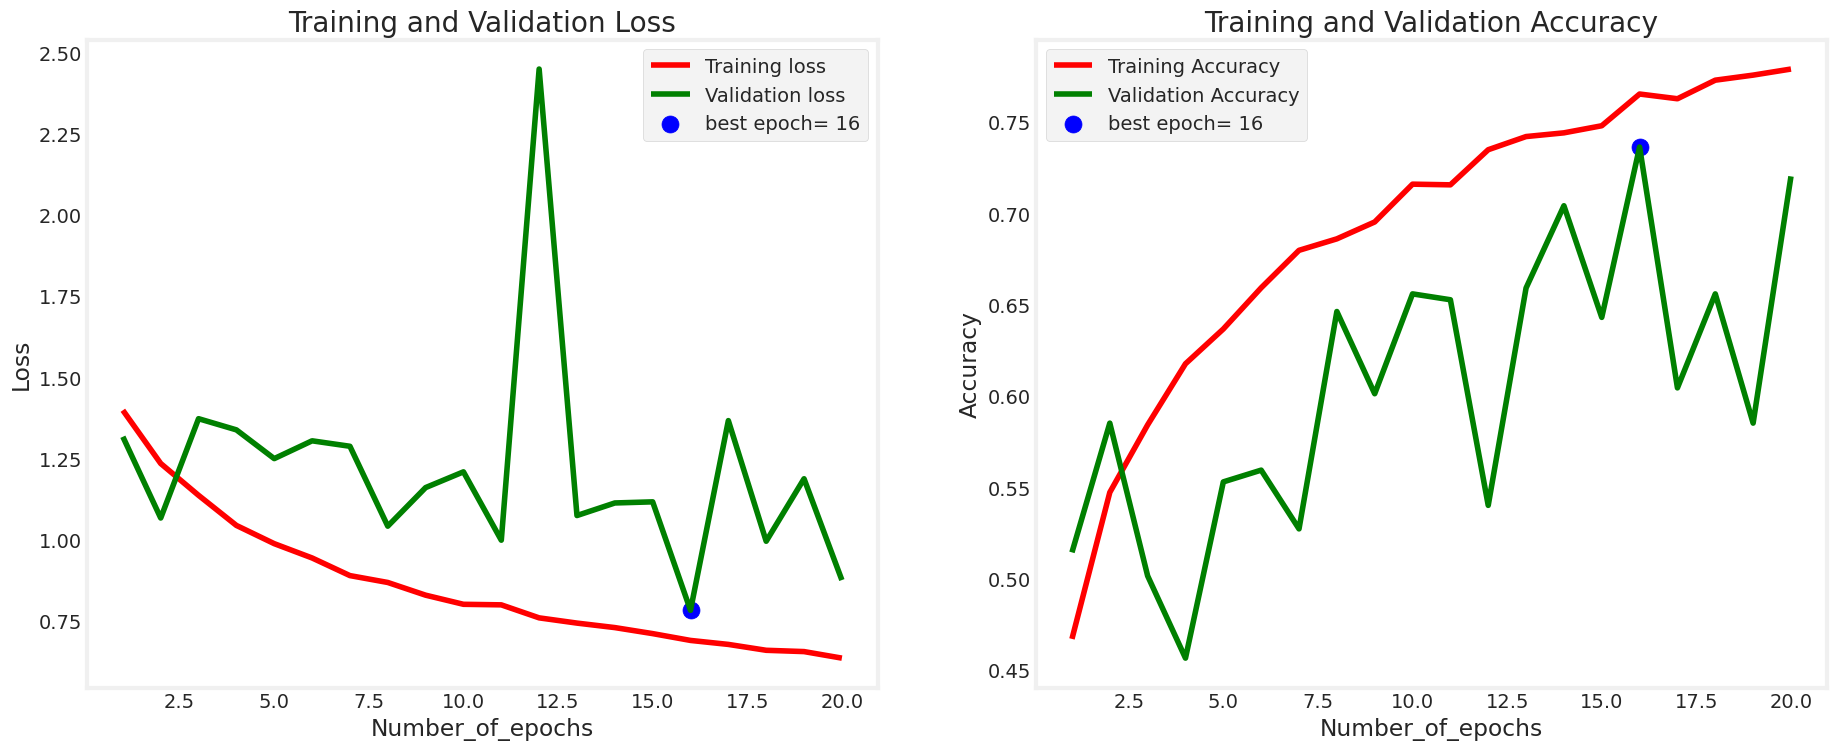

4/4 [==============================] - 1s 183ms/step - loss: 0.8029 - acc: 0.7724
accuracy on the test set is 77.24 %


In [ ]:
tr_plot(history,0)
acc=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print(msg)

In [ ]:
predicted_output=[]
for arr in preds:
    predicted_output.append(np.argmax(arr))
print(predicted_output)

[0, 1, 4, 0, 4, 3, 1, 1, 4, 5, 3, 3, 0, 3, 3, 4, 1, 4, 4, 0, 1, 1, 0, 1, 1, 5, 0, 5, 4, 1, 4, 3, 3, 0, 1, 4, 4, 4, 3, 4, 3, 1, 1, 5, 3, 0, 1, 5, 1, 4, 1, 1, 3, 3, 2, 3, 1, 2, 0, 5, 0, 4, 1, 5, 5, 5, 5, 2, 3, 0, 0, 0, 2, 5, 2, 5, 5, 2, 0, 0, 2, 1, 2, 5, 0, 2, 1, 0, 2, 1, 4, 1, 4, 5, 1, 2, 2, 0, 4, 1, 4, 0, 0, 0, 2, 3, 4, 3, 5, 0, 4, 0, 3, 0, 2, 3, 5, 5, 3, 5, 2, 0, 3, 2, 5, 2, 1, 2, 0, 4, 3, 3, 5, 5, 5, 5, 1, 3, 4, 1, 3, 2, 1, 2, 4, 5, 4, 4, 2, 2, 5, 5, 3, 0, 2, 3, 1, 0, 4, 3, 3, 4, 1, 5, 4, 3, 0, 0, 3, 3, 1, 2, 2, 2, 5, 3, 0, 5, 5, 5, 5, 5, 5, 3, 2, 2, 3, 0, 1, 1, 5, 2, 2, 0, 4, 1, 3, 3, 0, 0, 3, 3, 0, 5, 3, 0, 3, 2, 3, 1, 5, 5, 2, 5, 3, 3, 4, 2, 1, 3, 4, 1, 4, 5, 3, 5, 3, 4, 1, 1, 0, 5, 3, 3, 5, 1, 3, 3, 0, 4, 5, 0, 0, 1, 5, 3, 5, 4, 0, 5, 2, 1, 0, 3, 4, 1, 1, 2, 3, 3, 0, 1, 1, 0, 1, 1, 0, 1, 4, 3, 2, 0, 5, 3, 4, 3, 3, 4, 3, 0, 1, 5, 3, 0, 2, 1, 3, 4, 3, 0, 5, 5, 3, 5, 5, 2, 3, 2, 2, 0, 1, 3, 1, 2, 0, 3, 0, 0, 5, 2, 1, 2]


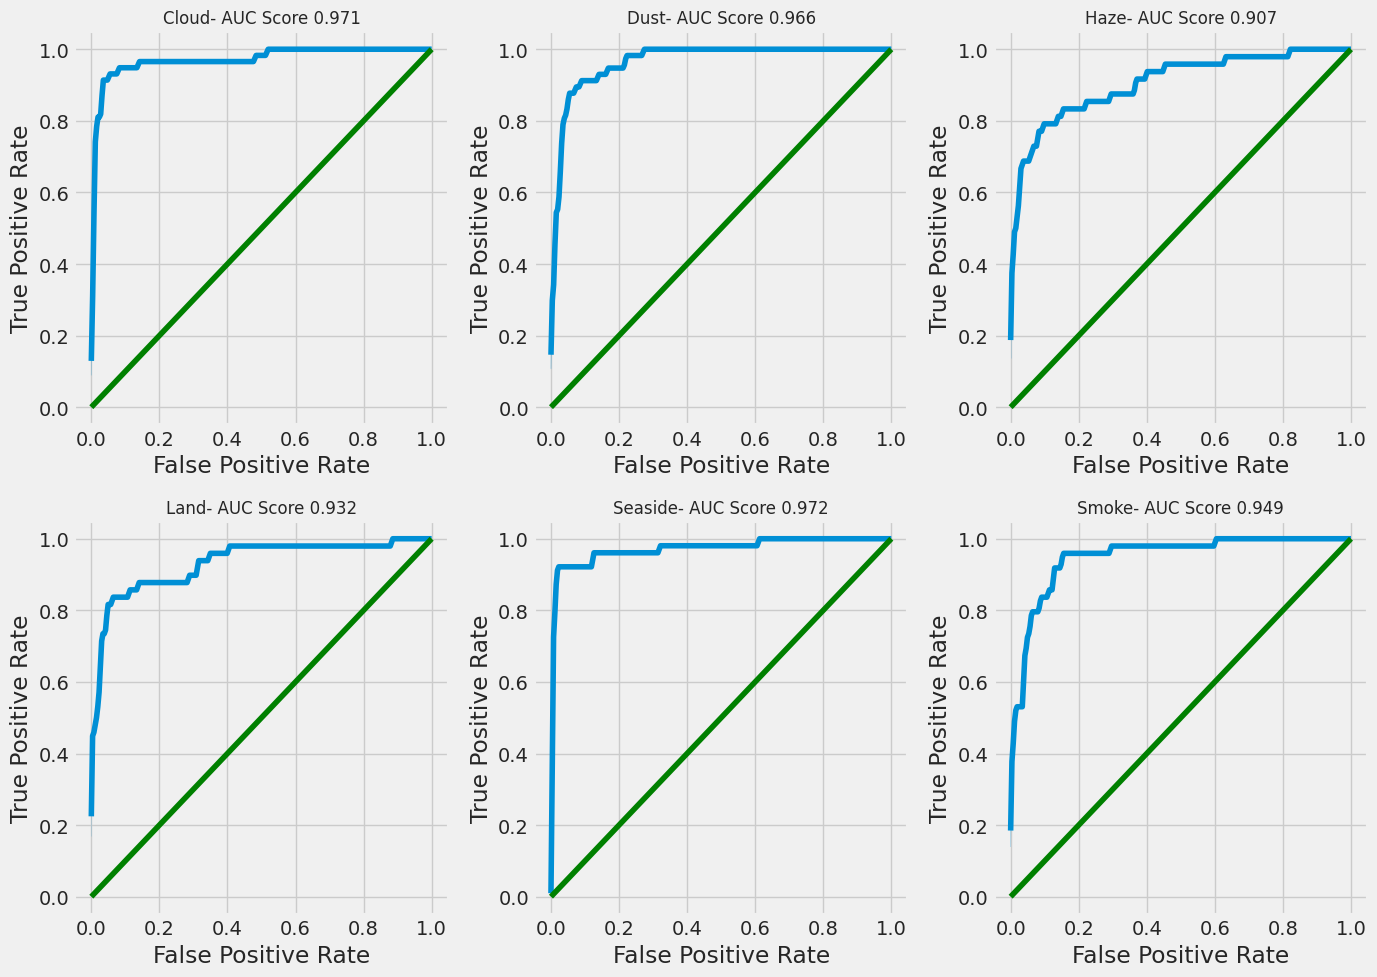

In [ ]:
def get_roc_values(real_values, probability):
    true_pos_rate_list = [0]
    false_pos_rate_list = [0]
    for i in range(len(probability)):
        limit = probability[i]
        predictions = probability >= limit
        true_pos_rate, false_pos_rate = cal_tpr_fpr(real_values, predictions)
        true_pos_rate_list.append(true_pos_rate)
        false_pos_rate_list.append(false_pos_rate)
    return true_pos_rate_list, false_pos_rate_list

#AUC-ROC Curve
def roc_curve_function( true_pos_rate, false_pos_rate,axis, scatter = True):
    if scatter:
        sns.scatterplot(x = false_pos_rate, y = true_pos_rate, axis = axis)
    sns.lineplot(x = false_pos_rate, y = true_pos_rate, ax = axis)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = axis)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")


def cal_tpr_fpr(original_val, predicted_val):
    new_matrix = confusion_matrix(original_val, predicted_val)
    TruePos = new_matrix[1, 1]
    TrueNeg = new_matrix[0, 0]
    FalsePos = new_matrix[0, 1]
    FalseNeg = new_matrix[1, 0]
    true_pos_rate =  TruePos/(TruePos + FalseNeg)
    false_pos_rate = 1 - TrueNeg/(TrueNeg+FalsePos)
    return true_pos_rate, false_pos_rate


plt.figure(figsize = (14, 10))
list_labels=['Cloud','Dust','Haze','Land','Seaside','Smoke']
new_df = pd.DataFrame()
bins = [i/20 for i in range(20)] + [1]
roc_auc_ovr = {}
for i in range(0,6):
    original = i
    new_df['class'] = [1 if predicted == original else 0 for predicted in test_gen.classes]
    new_df['probability'] = preds[:, i]
    new_df = new_df.reset_index(drop = True)
    bottom_axis = plt.subplot(2, 3, i+1)
    true_pos_rate, false_pos_rate = get_roc_values(new_df['class'], new_df['probability'])
    roc_curve_function(  true_pos_rate, false_pos_rate, axis = bottom_axis, scatter = False)
    auc_values = roc_auc_score(new_df['class'], new_df['probability'])
    bottom_axis.set_title(list_labels[i]+'- AUC Score '+str(format(auc_values,".3f")),fontsize=12)
plt.tight_layout()